In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import random

In [2]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link1 = 'https://drive.google.com/file/d/1ZeYz0HO1dIad7Qro9K5JPdK89D8CG-IB/view?usp=drive_link'
link2 = 'https://drive.google.com/file/d/1AnsDdnYT0giKcr9hljGN1vU-9RnlPHoK/view?usp=drive_link'

In [4]:
id1 = link1.split("/")[-2]
id2 = link2.split("/")[-2]

downloaded1 = drive.CreateFile({'id':id1})
downloaded1.GetContentFile('Spambase_train.csv')
downloaded2 = drive.CreateFile({'id':id2})
downloaded2.GetContentFile('Spambase_test.csv')

In [5]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path, header=None, names=['data'])

    features = df['data'].iloc[0].split('\t')  # Extract feature names from the first row
    df = df.iloc[1:]  # Remove the header row

    # Split each data row into features
    X = df['data'].str.split('\t', expand=True).astype(float)
    X.columns = features

    y = X.pop('Class')  # Extract the target class

    return X, y

X_train, y_train = preprocess_data("Spambase_train.csv")
X_test, y_test = preprocess_data("Spambase_test.csv")

In [6]:
def calculate_accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)

def monte_carlo_cv(X, y, C, validation_size=0.2):
    iterations = [k for k in range(1, 11)]
    errors = []
    for _ in tqdm(iterations):
        data = np.c_[X, y]  # Combine features and labels
        np.random.shuffle(data)  # Shuffle rows

        split_index = int(len(data) * (1 - validation_size))
        X_train, y_train = data[:split_index, :-1], data[:split_index, -1]
        X_val, y_val = data[split_index:, :-1], data[split_index:, -1]

        # Training the SVM
        model = SVC(kernel='linear', C=C)
        model.fit(X_train, y_train)

        # Evaluation
        y_pred = model.predict(X_val)
        error = 1 - calculate_accuracy(y_val, y_pred)
        errors.append(error)

    return sum(errors) / len(errors)

C_values = [0.01, 0.1, 1, 10, 100, 1000]

best_C = None
best_error = float('inf')
for C in C_values:
    error = monte_carlo_cv(X_train, y_train, C)
    print(f"Error for C={C}: {error:.4f}")  # Print error for each C value
    if error < best_error:
        best_C = C
        best_error = error

print("Best C value:", best_C)

100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Error for C=0.01: 0.1260


100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Error for C=0.1: 0.0896


100%|██████████| 10/10 [03:25<00:00, 20.51s/it]


Error for C=1: 0.0844


100%|██████████| 10/10 [21:07<00:00, 126.73s/it]


Error for C=10: 0.0823


100%|██████████| 10/10 [59:09<00:00, 354.95s/it]


Error for C=100: 0.1031


100%|██████████| 10/10 [50:23<00:00, 302.40s/it]

Error for C=1000: 0.0885
Best C value: 10


In [7]:
# Train the final model with the best C
model = SVC(kernel='linear', C=best_C)
model.fit(X_train, y_train)

# Prediction on test set
y_pred = model.predict(X_test)

def confusion_matrix(y_true, y_pred):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for true_label, predicted_label in zip(y_true, y_pred):
        if true_label == predicted_label and true_label == 1:
            tp += 1
        elif true_label == predicted_label and true_label == 0:
            tn += 1
        elif true_label != predicted_label and true_label == 0:
            fp += 1
        else:  # true_label != predicted_label and true_label == 1
            fn += 1

    return tp, fp, tn, fn

tp, fp, tn, fn = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", np.array([[tp, fp], [fn, tn]]))

def calculate_metrics(y_true, y_pred):
    tp, fp, tn, fn = confusion_matrix(y_true, y_pred)

    accuracy = (tp + tn) / (tp + tn + fp + fn)

    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    if tn + fn == 0:
        npv = 0
    else:
        npv = tn / (tn + fn)

    if fp + tn == 0:
        fpr = 0
    else:
        fpr = fp / (fp + tn)

    if fp + tp == 0:
        fdr = 0
    else:
        fdr = fp / (fp + tp)

    if (4 * precision + recall) == 0:
        f2 = 0
    else:
        f2 = (5 * precision * recall) / (4 * precision + recall)

    return accuracy, precision, recall, f1, npv, fpr, fdr, f2

# Calculate metrics
accuracy, precision, recall, f1, npv, fpr, fdr, f2 = calculate_metrics(y_test, y_pred)

# Print metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"F2 Score: {f2:.2f}")
print(f"Negative Predictive Value (NPV): {npv:.2f}")
print(f"False Positive Rate (FPR): {fpr:.2f}")
print(f"False Discovery Rate (FDR): {fdr:.2f}")

Confusion Matrix:
 [[47  5]
 [ 3 45]]
Performance Metrics:
Accuracy: 0.92
Precision: 0.90
Recall: 0.94
F1 Score: 0.92
F2 Score: 0.93
Negative Predictive Value (NPV): 0.94
False Positive Rate (FPR): 0.10
False Discovery Rate (FDR): 0.10


Error for C=0.01, d=2: 0.5208
Error for C=0.01, d=3: 0.5083
Error for C=0.01, d=4: 0.5146
Error for C=0.01, d=5: 0.5333
Error for C=0.1, d=2: 0.5385
Error for C=0.1, d=3: 0.5375
Error for C=0.1, d=4: 0.5052
Error for C=0.1, d=5: 0.5417
Error for C=1, d=2: 0.5125
Error for C=1, d=3: 0.4990
Error for C=1, d=4: 0.5177
Error for C=1, d=5: 0.4969
Error for C=10, d=2: 0.4792
Error for C=10, d=3: 0.4885
Error for C=10, d=4: 0.4823
Error for C=10, d=5: 0.4865
Error for C=100, d=2: 0.4292
Error for C=100, d=3: 0.4635
Error for C=100, d=4: 0.4719
Error for C=100, d=5: 0.4875
Error for C=1000, d=2: 0.3312
Error for C=1000, d=3: 0.4042
Error for C=1000, d=4: 0.4219
Error for C=1000, d=5: 0.4667


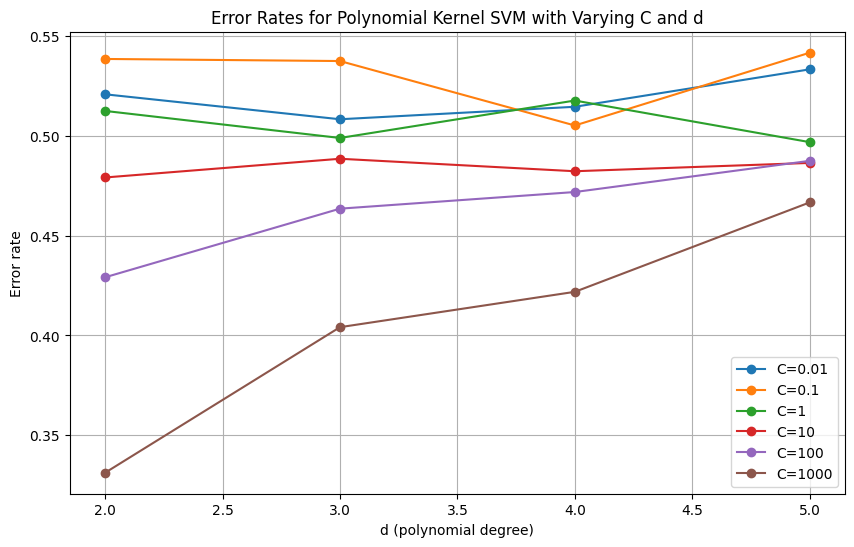

Best C value: 1000
Best d value: 2


In [17]:
def calculate_accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)

def polynomial_kernel_mccv(X, y, C, d, validation_size=0.2):
    iterations = [k for k in range(1, 11)]
    errors = []
    for _ in (iterations):
        data = np.c_[X, y]  # Combine features and labels
        np.random.shuffle(data)  # Shuffle rows

        split_index = int(len(data) * (1 - validation_size))
        X_train, y_train = data[:split_index, :-1], data[:split_index, -1]
        X_val, y_val = data[split_index:, :-1], data[split_index:, -1]

        # Train SVM with polynomial kernel
        model = SVC(kernel='poly', degree=d, C=C)
        model.fit(X_train, y_train)

        # Evaluation
        y_pred = model.predict(X_val)
        error = 1 - calculate_accuracy(y_val, y_pred)
        errors.append(error)

    return sum(errors) / len(errors)

# Load data
X_train, y_train = preprocess_data("Spambase_train.csv")
X_test, y_test = preprocess_data("Spambase_test.csv")

# Define hyperparameter ranges
C_values = [0.01, 0.1, 1, 10, 100, 1000]
d_values = [2, 3, 4, 5]

best_C = None
best_d = None
best_error = float('inf')
plt.figure(figsize=(10, 6))

error_results = {}
for C in C_values:
    for d in d_values:
        error = polynomial_kernel_mccv(X_train, y_train, C, d)
        print(f"Error for C={C}, d={d}: {error:.4f}")
        error_results[(C, d)] = error

        if error < best_error:
          best_C = C
          best_d = d
          best_error = error

for C in C_values:
    errors_for_C = [error_results[(C, d)] for d in d_values]
    plt.plot(d_values, errors_for_C, marker='o', label=f"C={C}")

plt.xlabel("d (polynomial degree)")
plt.ylabel("Error rate")
plt.title("Error Rates for Polynomial Kernel SVM with Varying C and d")
plt.legend()
plt.grid(True)
plt.show()

print("Best C value:", best_C)
print("Best d value:", best_d)

In [18]:
# Train the final model with the best C
model = SVC(kernel='poly', degree=best_d, C=best_C)
model.fit(X_train, y_train)

# Prediction on test set
y_pred = model.predict(X_test)

def confusion_matrix(y_true, y_pred):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for true_label, predicted_label in zip(y_true, y_pred):
        if true_label == predicted_label and true_label == 1:
            tp += 1
        elif true_label == predicted_label and true_label == 0:
            tn += 1
        elif true_label != predicted_label and true_label == 0:
            fp += 1
        else:  # true_label != predicted_label and true_label == 1
            fn += 1

    return tp, fp, tn, fn

tp, fp, tn, fn = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", np.array([[tp, fp], [fn, tn]]))

def calculate_metrics(y_true, y_pred):
    tp, fp, tn, fn = confusion_matrix(y_true, y_pred)

    accuracy = (tp + tn) / (tp + tn + fp + fn)

    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    if tn + fn == 0:
        npv = 0
    else:
        npv = tn / (tn + fn)

    if fp + tn == 0:
        fpr = 0
    else:
        fpr = fp / (fp + tn)

    if fp + tp == 0:
        fdr = 0
    else:
        fdr = fp / (fp + tp)

    if (4 * precision + recall) == 0:
        f2 = 0
    else:
        f2 = (5 * precision * recall) / (4 * precision + recall)

    return accuracy, precision, recall, f1, npv, fpr, fdr, f2

# Calculate metrics
accuracy, precision, recall, f1, npv, fpr, fdr, f2 = calculate_metrics(y_test, y_pred)

# Print metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"F2 Score: {f2:.2f}")
print(f"Negative Predictive Value (NPV): {npv:.2f}")
print(f"False Positive Rate (FPR): {fpr:.2f}")
print(f"False Discovery Rate (FDR): {fdr:.2f}")

Confusion Matrix:
 [[25  2]
 [25 48]]
Performance Metrics:
Accuracy: 0.73
Precision: 0.93
Recall: 0.50
F1 Score: 0.65
F2 Score: 0.55
Negative Predictive Value (NPV): 0.66
False Positive Rate (FPR): 0.04
False Discovery Rate (FDR): 0.07
